# Correlation between tasks being performed by the target and its power consumption
In this course we will use the `Simple serial` firmware to show how the power consumption in a microcontroller will depend on the kind or instructions it is performing.

**Goals:**
* Capturing a power trace with ChipWhisperer
* Making connections between various simple instructions and power traces

#### Prerequisites
- [x] *0_series* notebooks

## Setup
In order to make the target perform different instructions, we are going to hardcode those instructions into its source code. To make sure we don't mess with the original source code of the `Simple serial` firmware we are going to copy all the files first. The following bash block will create a new directory and copy the `simpleserial-base` code into it:

In [1]:
%%bash
cd ../../chipwhisperer/hardware/victims/firmware/
mkdir -p simpleserial-base-test1A && cp -r simpleserial-base/* $_
cd simpleserial-base-test1A

### Defining parameters, building firmware and connecting to CW
Next up is defining the correct parameters for our target board, building the firmware and connecting to the chipwhisperer hardware (by specifying `CRYPTO_TARGET=NONE`, we are not programming an encryption algorithm onto the target):

In [2]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'

In [3]:
%%bash -s "$PLATFORM"
cd ../../chipwhisperer/hardware/victims/firmware/simpleserial-base-test1A
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-base-CWLITEXMEGA.hex
rm -f -- simpleserial-base-CWLITEXMEGA.eep
rm -f -- simpleserial-base-CWLITEXMEGA.cof
rm -f -- simpleserial-base-CWLITEXMEGA.elf
rm -f -- simpleserial-base-CWLITEXMEGA.map
rm -f -- simpleserial-base-CWLITEXMEGA.sym
rm -f -- simpleserial-base-CWLITEXMEGA.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-base.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s
rm -f -- simpleserial-base.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d
rm -f -- simpleserial-base.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: simpleserial-base.c
avr-gcc -c -mmcu=atxmega1

.././simpleserial/simpleserial.c:18:0: warning: "CRC" redefined
 #define CRC 0xA6
 ^
In file included from /usr/lib/avr/include/avr/io.h:536:0,
                 from .././hal/hal.h:93,
                 from .././simpleserial/simpleserial.c:5:
/usr/lib/avr/include/avr/iox128d3.h:2240:0: note: this is the location of the previous definition
 #define CRC    (*(CRC_t *) 0x00D0)  /* Cyclic Redundancy Checker */
 ^


In [4]:
import chipwhisperer as cw
try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()
   
try:
    target = cw.target(scope)
except IOError:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope)

print("INFO: Found ChipWhisperer😍")

if "STM" in PLATFORM or PLATFORM == "CWLITEARM" or PLATFORM == "CWNANO":
    prog = cw.programmers.STM32FProgrammer
elif PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
    prog = cw.programmers.XMEGAProgrammer
else:
    prog = None
    
import time
time.sleep(0.05)
scope.default_setup()
def reset_target(scope):
    if PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
        scope.io.pdic = 'low'
        time.sleep(0.05)
        scope.io.pdic = 'high_z' #XMEGA doesn't like pdic driven high
        time.sleep(0.05)
    else:  
        scope.io.nrst = 'low'
        time.sleep(0.05)
        scope.io.nrst = 'high_z'
        time.sleep(0.05)

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


The code block which holds the code to connect to the ChipWhisperer and check the connection is quite large. Therefore we put all of this code in a helper script so we can run that helper script from within a notebook by just using one line of code. (As you will see in later tutorials)

### Uploading the firmware to the target device
This can easily be done as we have already done once before:

In [5]:
cw.program_target(scope, prog, "../../chipwhisperer/hardware/victims/firmware/simpleserial-base-test1A/simpleserial-base-{}.hex".format(PLATFORM))

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 2095 bytes


### Capturing a power trace
In order to capture and plot a power trace like we did last time, we will define a function so that we dont need to copy those lines of code everytime:

<IPython.core.display.Javascript object>


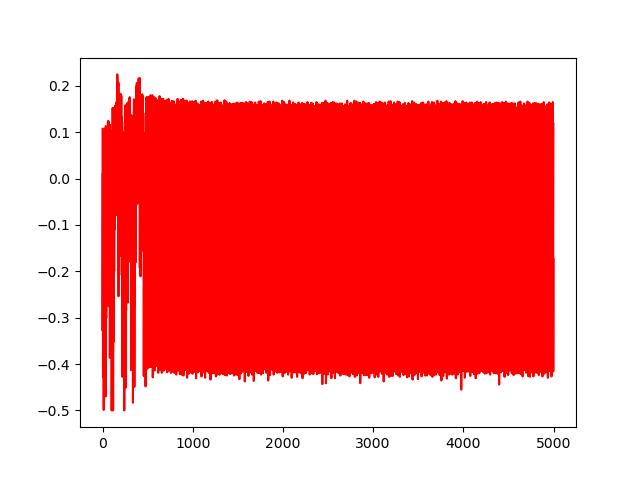

array([ 0.10742188, -0.328125  , -0.15527344, ..., -0.41601562,
       -0.21191406, -0.17382812])

In [6]:
%matplotlib notebook
import matplotlib.pylab as plt

def capture_plot_trace():
    scope.arm()
    msg = bytearray([0]*16)
    target.simpleserial_write('p', msg)
    scope.capture()
    trace = scope.get_last_trace()
    plt.figure()
    plt.plot(trace, 'r')
    plt.show()
    return trace

capture_plot_trace()

As you can tell from the graph above, the microcontroller does not seem to be doing a lot. To change this we dive into the source code of simple_serial and we add some nonesense instructions. 

## Changing the Simple serial base source code
To start off, let's insert some simple instructions to see if they're visible in the power trace. We're mostly looking for an instruction that executes in a single cycle.

To open the source file we just created (by copying the simple-serial-base directory) [click here](http://localhost:8888/edit/chipwhisperer/hardware/victims/firmware/simpleserial-base-test1A/simpleserial-base.c). You can edit the file right in the browser.

Find this part of the code:

```C
    #if SS_VER == SS_VER_2_0
    uint8_t get_pt(uint8_t cmd, uint8_t scmd, uint8_t len, uint8_t* pt)
    #else
    uint8_t get_pt(uint8_t* pt, uint8_t len)
    #endif

    {
        /**********************************
        * Start user-specific code here. */
        trigger_high();

        //16 hex bytes held in 'pt' were sent
        //from the computer. Store your response
        //back into 'pt', which will send 16 bytes
        //back to computer. Can ignore of course if
        //not needed

        trigger_low();
        /* End user-specific code here. *
        ********************************/
        simpleserial_put('r', 16, pt);
        return 0x00;
    }
```

**Insert the following code right before the line `simpleserial_put('r', 16, pt);`**

```C

	volatile long int A = 0x2BAA;
	A += 2;
	A += 2;
	A += 2;
	A += 2;
	A += 2;
	
	A += 2;
	A += 2;
	A += 2;
	A += 2;
	A += 2;

	A += 2;
	A += 2;
	A += 2;
	A += 2;
	A += 2;
	
	A += 2;
	A += 2;
	A += 2;
	A += 2;
	A += 2;
```

Now that we changed the source file, we need to recompile the firmware, reprogram the target with the new firmware and again capture a trace. (Run the next few code blocks to achieve this). **Don't forget to save the changed file (using the webbrowser editor) before recompiling!**

In [8]:
%%bash -s "$PLATFORM"
cd ../../chipwhisperer/hardware/victims/firmware/simpleserial-base-test1A
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-base-CWLITEXMEGA.hex
rm -f -- simpleserial-base-CWLITEXMEGA.eep
rm -f -- simpleserial-base-CWLITEXMEGA.cof
rm -f -- simpleserial-base-CWLITEXMEGA.elf
rm -f -- simpleserial-base-CWLITEXMEGA.map
rm -f -- simpleserial-base-CWLITEXMEGA.sym
rm -f -- simpleserial-base-CWLITEXMEGA.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-base.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s
rm -f -- simpleserial-base.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d
rm -f -- simpleserial-base.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: simpleserial-base.c
avr-gcc -c -mmcu=atxmega1

.././simpleserial/simpleserial.c:18:0: warning: "CRC" redefined
 #define CRC 0xA6
 ^
In file included from /usr/lib/avr/include/avr/io.h:536:0,
                 from .././hal/hal.h:93,
                 from .././simpleserial/simpleserial.c:5:
/usr/lib/avr/include/avr/iox128d3.h:2240:0: note: this is the location of the previous definition
 #define CRC    (*(CRC_t *) 0x00D0)  /* Cyclic Redundancy Checker */
 ^


In [9]:
cw.program_target(scope, prog, "../../chipwhisperer/hardware/victims/firmware/simpleserial-base-test1A/simpleserial-base-{}.hex".format(PLATFORM))

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 2621 bytes


<IPython.core.display.Javascript object>


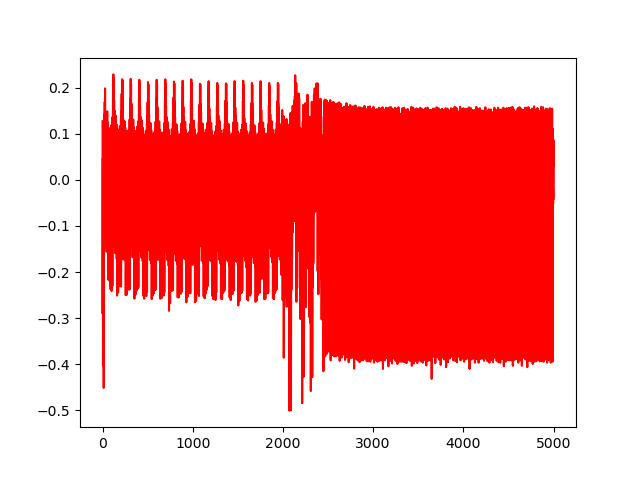

array([ 0.12695312, -0.29003906, -0.1171875 , ..., -0.04296875,
        0.08691406,  0.03125   ])

In [10]:
capture_plot_trace()

You should see a different graph than you did before. Furthermore, you should see a pattern in the beginning of the trace that repeats approximately 20 times. You get 3 seconds to figure out what the cause of this repeating pattern could be ...

1,2,3

...of course it can be related to the same instruction `A += 2;` that we made the microcontroller perform 20 times.
That doesn't seem that hard to understand but it is a fundamental part in understanding side-channel analysis attacks. We can learn something about the inner workings of a target by just monitoring its power consumption.

#### let's mix it up a bit
Every programmer knows that most of the times if we want to perform a piece of code 20 times we don't just copy the code 20 times. Try letting the target perform the same instructions but this time using a for loop. ([source file](http://localhost:8888/edit/chipwhisperer/hardware/victims/firmware/simpleserial-base-test1A/simpleserial-base.c#))

###START SOLUTION###
```C
    volatile long int A = 0x2BAA;
    for (int i = 0;i<20;i++){
        A += 2;
    }  

```
###END SOLUTION###

Again, don't forget to save the chages and use the blocks below to see the results:

In [11]:
%%bash -s "$PLATFORM"
cd ../../chipwhisperer/hardware/victims/firmware/simpleserial-base-test1A
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-base-CWLITEXMEGA.hex
rm -f -- simpleserial-base-CWLITEXMEGA.eep
rm -f -- simpleserial-base-CWLITEXMEGA.cof
rm -f -- simpleserial-base-CWLITEXMEGA.elf
rm -f -- simpleserial-base-CWLITEXMEGA.map
rm -f -- simpleserial-base-CWLITEXMEGA.sym
rm -f -- simpleserial-base-CWLITEXMEGA.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-base.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s
rm -f -- simpleserial-base.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d
rm -f -- simpleserial-base.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: simpleserial-base.c
avr-gcc -c -mmcu=atxmega1

.././simpleserial/simpleserial.c:18:0: warning: "CRC" redefined
 #define CRC 0xA6
 ^
In file included from /usr/lib/avr/include/avr/io.h:536:0,
                 from .././hal/hal.h:93,
                 from .././simpleserial/simpleserial.c:5:
/usr/lib/avr/include/avr/iox128d3.h:2240:0: note: this is the location of the previous definition
 #define CRC    (*(CRC_t *) 0x00D0)  /* Cyclic Redundancy Checker */
 ^


In [12]:
cw.program_target(scope, prog, "../../chipwhisperer/hardware/victims/firmware/simpleserial-base-test1A/simpleserial-base-{}.hex".format(PLATFORM))

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 2185 bytes


<IPython.core.display.Javascript object>


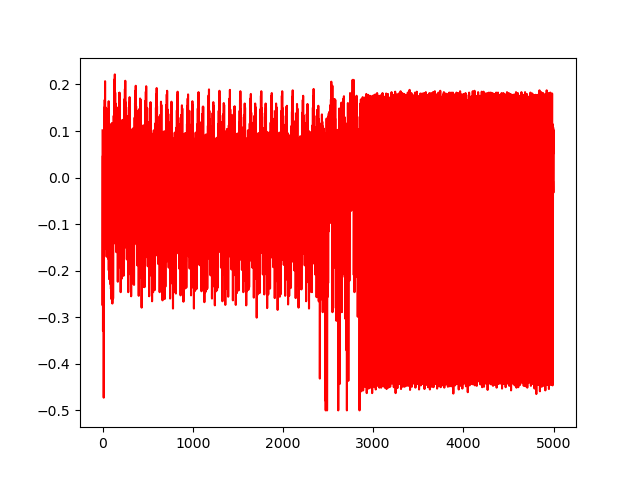

In [14]:
capture_plot_trace()

**Notice that the trace is slighly different while we are still performing the same 20 additions. Also notice that the total amount of 'time' is takes to complete all 20 instructions is longer this time!**

*-TIP: if you need to scroll a lot between the graphs, you can simply clear some output of the compile and program code blocks. Select the cell which output you want to clear and in the menu above select: `Cell -> Current Outputs -> Clear`*. Or select the block (blue border, not green) and press `o` to toggle the output on and off.

The longer time can be explained by the extra overhead a microcontroller needs to perform to do a for-loop instead of just running 20 instructions after each other.

#### More expensive instructions.
Now that we have seen what the power consumption of the target looks like while performing a simple instruction (can be performed in one clock cycle), let's look at a more expensive instruction for the XMEGA. Change the instruction inside the for loop to this:
```C
    A = A*A;
```

And yet again save the file and use the following code blocks to compile, program, capture and plot:

In [20]:
%%bash -s "$PLATFORM"
cd ../../chipwhisperer/hardware/victims/firmware/simpleserial-base-test1A
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-base-CWLITEXMEGA.hex
rm -f -- simpleserial-base-CWLITEXMEGA.eep
rm -f -- simpleserial-base-CWLITEXMEGA.cof
rm -f -- simpleserial-base-CWLITEXMEGA.elf
rm -f -- simpleserial-base-CWLITEXMEGA.map
rm -f -- simpleserial-base-CWLITEXMEGA.sym
rm -f -- simpleserial-base-CWLITEXMEGA.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-base.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s
rm -f -- simpleserial-base.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d
rm -f -- simpleserial-base.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: simpleserial-base.c
avr-gcc -c -mmcu=atxmega1

.././simpleserial/simpleserial.c:18:0: warning: "CRC" redefined
 #define CRC 0xA6
 ^
In file included from /usr/lib/avr/include/avr/io.h:536:0,
                 from .././hal/hal.h:93,
                 from .././simpleserial/simpleserial.c:5:
/usr/lib/avr/include/avr/iox128d3.h:2240:0: note: this is the location of the previous definition
 #define CRC    (*(CRC_t *) 0x00D0)  /* Cyclic Redundancy Checker */
 ^


In [21]:
cw.program_target(scope, prog, "../../chipwhisperer/hardware/victims/firmware/simpleserial-base-test1A/simpleserial-base-{}.hex".format(PLATFORM))

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 2263 bytes


<IPython.core.display.Javascript object>


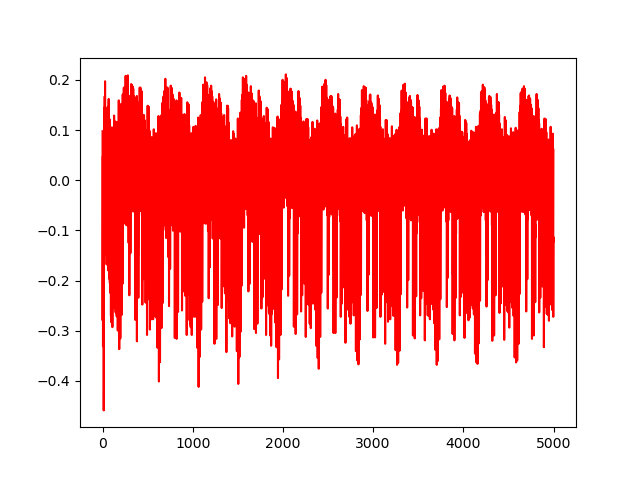

In [22]:
data4 = capture_plot_trace()

This time the instruction takes so long that the chipwhisperer wasn't even able to capture all 20 instructions in 5000 power measurements.

**HINT: In order to measure current, ChipWhisperer measures voltage drop across a shunt resistor. This means that the power trace is actually inverted (aka large negative swings are areas of higher power consumption).**

## Clean up
Run the next couple of blocks to delete the directory we created in the beginning of this notebook and to disconnect from the scope and the target.

In [25]:
%%bash -s "$PLATFORM"
cd ../../chipwhisperer/hardware/victims/firmware/
rm -r 'simpleserial-base-test1A'

In [26]:
scope.dis()
target.dis()

## Next step
Hopefully you now clearly understand that the instructions a target (microcontroller) performs correlates to the power consumption of the device. In the next lesson we will use this leakage of information to our advantage and find the hidden key of an asymmetric cryptographic algorithm.

**Next notebook click here: [1_B - Attack on RSA.ipynb](1_B%20-%20Attack%20on%20RSA.ipynb)**
